In [1]:
import sys
import numpy as np
import xarray as xr
from scipy import stats
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mplcolors
from matplotlib.colors import Normalize
#from numba import jit
import seaborn as sns
import Ngl
from utilities import *
%matplotlib inline
gw = xr.open_dataset('../pp_data/gw.nc',decode_times=False)['gw'].squeeze()

In [2]:
#some constants
H  = 7.0e3
a = 6.37e6
g  = 9.8
om = 7.292e-5  
R = 287.05
Cp = 1.0035e3

In [3]:
class MidpointNormalize(Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

In [4]:
def differentiate_DA(DataArray):
    dDAdt = DataArray.copy(deep=True)
    dDAdt[:] = 0.0
    dDAdt[:] = np.gradient(DataArray,DataArray['time']*365,axis=0,edge_order=2)
    return dDAdt

In [5]:
colors=colordefs()
norm = MidpointNormalize(midpoint=0)
label_size = 12
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size 

In [102]:
def interpolator(DataArray,hyam,hybm,PS,P0,debug=False):
    var = DataArray
    
    P0 = P0.values
    time=var.time
    ntime = time.shape[0]
    lat = var.lat
    nlat = lat.shape[0]
    nlon = 4
    phi = np.deg2rad(lat)
    lev = var.lev
    nlev = lev.shape[0]
    #zp = H*np.log(P0/(100*lev))
    #zpi = H*np.log(P0/(100*ilev))
    #rho = P0/(g*H) * np.exp(-zp/H)
    
    if debug:
        print('making dummies')
    
    dummy_arr = np.zeros(shape=[ntime,nlev,nlat])
    dummy_out = xr.DataArray(data=dummy_arr,dims=('time','lev','lat'),coords={'time':time,'lev':lev,'lat':lat})
    
    varp = dummy_out.copy(deep=True)
    
        
    if debug:
        print('Interpolating...')
    varp[:] = Ngl.vinth2p(np.broadcast_to(var.values[...,None],var.shape+(nlon,)),hyam.values,hybm.values,lev.values,np.broadcast_to(PS.values[...,None],PS.shape+(nlon,)),1,P0/100,1,True).mean(axis=-1)
    
    return varp
    

# Get necessary data

In [7]:
ens_zonmean = xr.open_dataset('../pp_data/bwma1850.f09.ens.los_chocoyos.cam.h0.pre+ALLYEARS_rev000.zonmean.nc',decode_times=False).sel(time=slice(-1,38.99))

In [8]:
sulf_zonmean = xr.open_dataset('../pp_data/bwma1850.f09.y13.los_chocoyos.qboE.ensoN.clone.SO2.cam.h0.0013-0047.zonmean.nc',decode_times=False)
replacement_time = (np.arange(sulf_zonmean.time.shape[0])/12.)
sulf_zonmean.time.values=replacement_time

In [9]:
sulf_zonmean_U=xr.concat([ens_zonmean['U'].sel(record=0).sel(time=slice(-1,-0.0001)),sulf_zonmean['U']],dim='time')
sulf_zonmean_T=xr.concat([ens_zonmean['T'].sel(record=0).sel(time=slice(-1,-0.0001)),sulf_zonmean['T']],dim='time')
sulf_zonmean_PS=xr.concat([ens_zonmean['PS'].sel(record=0).sel(time=slice(-1,-0.0001)),sulf_zonmean['PS']],dim='time')

In [10]:
sulf30_zonmean = xr.open_dataset('../pp_data/bwma1850.f09.y30.los_chocoyos.qboW.ensoN.SO2.cam.h0.0030-0064.zonmean.nc',decode_times=False)
replacement_time = (np.arange(sulf30_zonmean.time.shape[0])/12.)
sulf30_zonmean.time.values=replacement_time

In [11]:
sulf30_zonmean_U=xr.concat([ens_zonmean['U'].sel(record=3).sel(time=slice(-1,-0.0001)),sulf30_zonmean['U']],dim='time')
sulf30_zonmean_T=xr.concat([ens_zonmean['T'].sel(record=3).sel(time=slice(-1,-0.0001)),sulf30_zonmean['T']],dim='time')
sulf30_zonmean_PS = xr.concat([ens_zonmean['PS'].sel(record=3).sel(time=slice(-1,-0.0001)),sulf30_zonmean['PS']],dim='time')

In [12]:
sulf_1pc_zonmean = xr.open_dataset('../pp_data/bwma1850.f09.y13.los_chocoyos.qboE.ensoN.clone.1pc_SO2.cam.h0.0013-0022.zonmean.nc',decode_times=False)
replacement_time = (np.arange(sulf_1pc_zonmean.time.shape[0])/12.)
sulf_1pc_zonmean.time.values=replacement_time

In [13]:
sulf_1pc_zonmean_U=xr.concat([ens_zonmean['U'].sel(record=0).sel(time=slice(-1,-0.0001)),sulf_1pc_zonmean['U']],dim='time')
sulf_1pc_zonmean_T=xr.concat([ens_zonmean['T'].sel(record=0).sel(time=slice(-1,-0.0001)),sulf_1pc_zonmean['T']],dim='time')
sulf_1pc_zonmean_PS=xr.concat([ens_zonmean['PS'].sel(record=0).sel(time=slice(-1,-0.0001)),sulf_1pc_zonmean['PS']],dim='time')

In [14]:
halog_1pc_zonmean = xr.open_dataset('../pp_data/bwma1850.f09.y13.los_chocoyos.qboE.ensoN.1pc_halog.cam.h0.0013-0048.zonmean.nc',decode_times=False)
replacement_time = (np.arange(halog_1pc_zonmean.time.shape[0])/12.)
halog_1pc_zonmean.time.values=replacement_time

In [15]:
halog_1pc_zonmean_U=xr.concat([ens_zonmean['U'].sel(record=0).sel(time=slice(-1,-0.0001)),halog_1pc_zonmean['U']],dim='time')
halog_1pc_zonmean_T=xr.concat([ens_zonmean['T'].sel(record=0).sel(time=slice(-1,-0.0001)),halog_1pc_zonmean['T']],dim='time')
halog_1pc_zonmean_PS=xr.concat([ens_zonmean['PS'].sel(record=0).sel(time=slice(-1,-0.0001)),halog_1pc_zonmean['PS']],dim='time')

In [16]:
climzon = xr.open_dataset('../pp_data/bwma1850.f09.test1.cam.h0.year.zonmean.nc',decode_times=False)


In [17]:
ctrzon = xr.open_dataset('../pp_data/bwma1850.f09.test1.clone.cam.h0.0005-0082.zonmean.nc',decode_times=False)
ctrzon.time.values = np.arange(ctrzon.time.shape[0])/12.
ctrzon = ctrzon.isel(time=slice(5*12,1000))
ctrzon.time.values = np.arange(ctrzon.time.shape[0])/12.

In [18]:
f = 2*om*np.sin(np.deg2rad(climzon.lat.squeeze().values))

In [19]:
hyam = sulf_zonmean.hyam
hybm = sulf_zonmean.hybm
P0 = sulf_zonmean.P0

## Make temp. anomalies

In [20]:
climTconcat = get_clim_with_same_dims_v2(ens_zonmean['T'],climzon['T'])
replacement_time = (np.arange(climTconcat.time.shape[0])/12.)
climTconcat['time'].values=replacement_time
ens_zonmean_T_anom = ens_zonmean['T']-climTconcat.values

In [21]:
climTconcat_sulf = get_clim_with_same_dims_v2(sulf_zonmean_T,climzon['T'])
climTconcat_sulf['time'].values=sulf_zonmean_T['time'].values
sulf_zonmean_T_anom = sulf_zonmean_T-climTconcat_sulf.values

In [22]:
climTconcat_sulf30 = get_clim_with_same_dims_v2(sulf30_zonmean_T,climzon['T'])
climTconcat_sulf30['time'].values=sulf30_zonmean_T['time'].values
sulf30_zonmean_T_anom = sulf30_zonmean_T-climTconcat_sulf.values

In [23]:
climTconcat_1pcsulf = get_clim_with_same_dims_v2(sulf_1pc_zonmean_T,climzon['T'])
climTconcat_1pcsulf['time'].values=sulf_1pc_zonmean_T['time'].values
sulf_1pc_zonmean_T_anom = sulf_1pc_zonmean_T-climTconcat_1pcsulf.values

In [24]:
climTconcat_1pchalog = get_clim_with_same_dims_v2(halog_1pc_zonmean_T,climzon['T'])
climTconcat_1pchalog['time'].values=halog_1pc_zonmean_T['time'].values
halog_1pc_zonmean_T_anom = halog_1pc_zonmean_T-climTconcat_1pchalog.values

# Plot QBO

# QBO composites

In [25]:
test=sns.diverging_palette(255,15,sep=1,s=99,l=40,as_cmap=True)

In [26]:
def qbo_plot(wind,tanom,pmin=1,pmax=200,tmin=-1,tmax=15,cf_levels=np.linspace(-50,50,21),
             cs_levels=np.linspace(-40,40,9),figsize=(8,3),cmap=test,title='dummy',
             xlabel='Years since eruption',clblabel='Zonal wind [m/s]',cs_color='black'):
    
    plt.figure(figsize=figsize)
    CF = wind.sel(lev=slice(pmin*0.9,pmax)).sel(lat=slice(-2,2)).reduce(np.average,dim='lat',weights=gw.sel(lat=slice(-2,2))).plot.contourf(x='time',levels=cf_levels,cmap=cmap,add_colorbar=False,extend='both')
    CS = tanom.sel(lev=slice(pmin*0.9,pmax)).sel(lat=slice(-2,2)).reduce(np.average,dim='lat',weights=gw.sel(lat=slice(-2,2))).plot.contour(x='time',levels=cs_levels,colors='black',add_colorbar=False)
#     CS.monochrome = True
    for line, lvl in zip(CS.collections, CS.levels):
        if lvl < 0:
            line.set_linestyle('--')
            line.set_color(cs_color)
        elif lvl == 0:
            line.set_linestyle(':')
        else:
            # Optional; this is the default.
            line.set_linestyle('-')
            line.set_color(cs_color)
    plt.clabel(CS,fmt='%1.0f',inline_spacing=1)
    plt.vlines(0,0.001,1000,linestyle='--')
    plt.yscale('log')
    plt.gca().invert_yaxis()
    clb=plt.colorbar(CF,pad=0.01)
    clb.set_label(clblabel,fontsize=13)
    plt.xlim([tmin,tmax])
    plt.ylim([pmax,pmin])
    plt.xlabel(xlabel,fontsize=13)
    ax=plt.gca()
    ax.tick_params(axis='both', which='major', labelsize=12)
    plt.ylabel('Pressure level [hPa]',fontsize=13)
    plt.title(title,fontsize=13)

In [55]:
QBOE_U_comp = ens_zonmean['U'].sel(record=[0,1,2]).mean(dim='record')
QBOW_U_comp = ens_zonmean['U'].sel(record=[3,4,5]).mean(dim='record').isel(time=slice(0,432))

QBOE_PS_comp = ens_zonmean['PS'].sel(record=[0,1,2]).mean(dim='record')
QBOW_PS_comp = ens_zonmean['PS'].sel(record=[3,4,5]).mean(dim='record').isel(time=slice(0,432))

In [56]:
QBOE_Ta_comp = ens_zonmean_T_anom.sel(record=[0,1,2]).mean(dim='record')
QBOW_Ta_comp = ens_zonmean_T_anom.sel(record=[3,4,5]).mean(dim='record').isel(time=slice(0,432))

In [57]:
QBOE_T_comp = ens_zonmean['T'].sel(record=[0,1,2]).mean(dim='record')
QBOW_T_comp = ens_zonmean['T'].sel(record=[3,4,5]).mean(dim='record').isel(time=slice(0,432))


### Vertically interpolate all necessary fields to pressure coordinates

In [65]:
QBOE_U_comp[:] = interpolator(QBOE_U_comp,hyam,hybm,QBOE_PS_comp,P0).values

QBOW_U_comp[:] = interpolator(QBOW_U_comp,hyam,hybm,QBOW_PS_comp,P0).values

QBOE_Ta_comp[:] = interpolator(QBOE_Ta_comp,hyam,hybm,QBOE_PS_comp,P0).values

QBOW_Ta_comp[:] = interpolator(QBOW_Ta_comp,hyam,hybm,QBOW_PS_comp,P0).values

QBOE_T_comp[:] = interpolator(QBOE_T_comp,hyam,hybm,QBOE_PS_comp,P0).values

QBOW_T_comp[:] = interpolator(QBOW_T_comp,hyam,hybm,QBOW_PS_comp,P0).values

In [66]:
sulf_1pc_zonmean_U[:] = interpolator(sulf_1pc_zonmean_U,hyam,hybm,sulf_1pc_zonmean_PS,P0).values
sulf_1pc_zonmean_T_anom[:] = interpolator(sulf_1pc_zonmean_T_anom,hyam,hybm,sulf_1pc_zonmean_PS,P0).values
sulf_1pc_zonmean_T[:] = interpolator(sulf_1pc_zonmean_T,hyam,hybm,sulf_1pc_zonmean_PS,P0).values

making dummies
Interpolating...
making dummies
Interpolating...
making dummies
Interpolating...


In [67]:
sulf_zonmean_U[:] = interpolator(sulf_zonmean_U,hyam,hybm,sulf_zonmean_PS,P0).values
sulf_zonmean_T_anom[:] = interpolator(sulf_zonmean_T_anom,hyam,hybm,sulf_zonmean_PS,P0).values
sulf_zonmean_T[:] = interpolator(sulf_zonmean_T,hyam,hybm,sulf_zonmean_PS,P0).values

making dummies
Interpolating...
making dummies
Interpolating...
making dummies
Interpolating...


In [68]:
sulf30_zonmean_U[:] = interpolator(sulf30_zonmean_U,hyam,hybm,sulf30_zonmean_PS,P0).values
sulf30_zonmean_T[:] = interpolator(sulf30_zonmean_T,hyam,hybm,sulf30_zonmean_PS,P0).values
sulf30_zonmean_T_anom[:] = interpolator(sulf30_zonmean_T_anom,hyam,hybm,sulf30_zonmean_PS,P0).values

making dummies
Interpolating...
making dummies
Interpolating...
making dummies
Interpolating...


In [69]:
halog_1pc_zonmean_U[:] = interpolator(halog_1pc_zonmean_U,hyam,hybm,halog_1pc_zonmean_PS,P0).values
halog_1pc_zonmean_T[:] = interpolator(halog_1pc_zonmean_T,hyam,hybm,halog_1pc_zonmean_PS,P0).values
halog_1pc_zonmean_T_anom[:] = interpolator(halog_1pc_zonmean_T_anom,hyam,hybm,halog_1pc_zonmean_PS,P0).values

making dummies
Interpolating...
making dummies
Interpolating...
making dummies
Interpolating...


### Some derived quantities

In [70]:
QBOE_dUdz_comp = differentiate_DA_z(QBOE_U_comp)*1000
QBOW_dUdz_comp = differentiate_DA_z(QBOW_U_comp)*1000

In [71]:
sulf30_zonmean_dUdz = differentiate_DA_z(sulf30_zonmean_U)*1000
sulf_zonmean_dUdz = differentiate_DA_z(sulf_zonmean_U)*1000

In [72]:
sulf1_zonmean_dUdz = differentiate_DA_z(sulf_1pc_zonmean_U)*1000

In [73]:
halog1_zonmean_dUdz = differentiate_DA_z(halog_1pc_zonmean_U)*1000

### LCY_full.qboE wind and shear

findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.


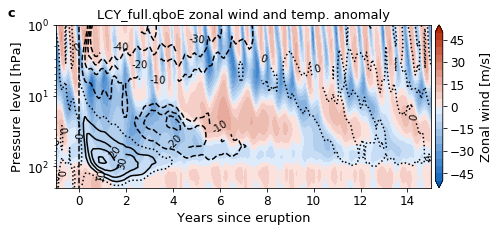

In [74]:
qbo_plot(QBOE_U_comp,QBOE_Ta_comp,title='LCY_full.qboE zonal wind and temp. anomaly')
plt.gca().text(-0.13,1.05,'c',transform=plt.gca().transAxes,fontsize=13,weight='bold',fontname='arial')
plt.savefig('LCY_full.qboE_QBO.png',dpi=300,bbox_inches='tight')

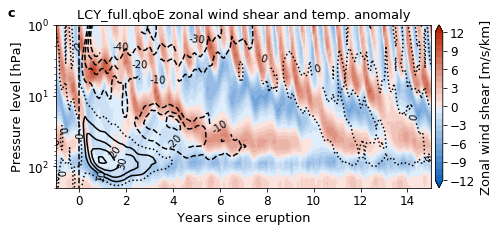

In [75]:
qbo_plot(QBOE_dUdz_comp,QBOE_Ta_comp,cf_levels=np.linspace(-12,12,25),clblabel='Zonal wind shear [m/s/km]',title='LCY_full.qboE zonal wind shear and temp. anomaly')
plt.gca().text(-0.13,1.05,'c',transform=plt.gca().transAxes,fontsize=13,weight='bold',fontname='arial')
plt.savefig('LCY_full.qboE_QBO_shear.png',dpi=300,bbox_inches='tight')

In [76]:
QBOE_Ty = differentiate_DA_lat(QBOE_T_comp)
QBOE_Tyy = differentiate_DA_lat(differentiate_DA_lat(QBOE_T_comp))

QBOE_TWB_dUdz = (-R*QBOE_Tyy/(H*2*om/a))*1000

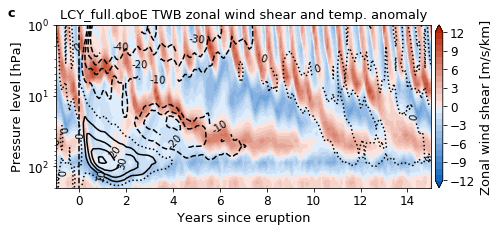

In [77]:
qbo_plot(QBOE_TWB_dUdz,QBOE_Ta_comp,cf_levels=np.linspace(-12,12,25),title='LCY_full.qboE TWB zonal wind shear and temp. anomaly',clblabel='Zonal wind shear [m/s/km]')
plt.gca().text(-0.13,1.05,'c',transform=plt.gca().transAxes,fontsize=13,weight='bold',fontname='arial')
plt.savefig('LCY_full.qboE_QBO_TWB.png',dpi=300,bbox_inches='tight')

### LCY_full.qboW wind and shear

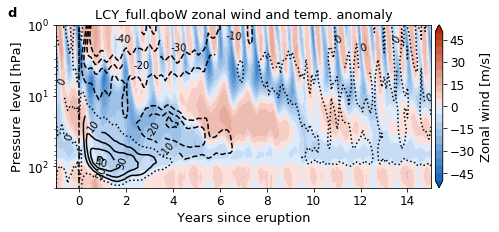

In [78]:
qbo_plot(QBOW_U_comp,QBOW_Ta_comp,title='LCY_full.qboW zonal wind and temp. anomaly')
plt.gca().text(-0.13,1.05,'d',transform=plt.gca().transAxes,fontsize=13,weight='bold',fontname='arial')
plt.savefig('LCY_full.qboW_QBO.png',dpi=300,bbox_inches='tight')

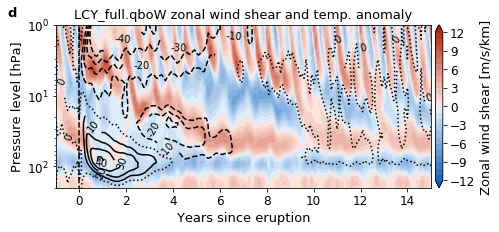

In [79]:
qbo_plot(QBOW_dUdz_comp,QBOW_Ta_comp,cf_levels=np.linspace(-12,12,25),title='LCY_full.qboW zonal wind shear and temp. anomaly',clblabel='Zonal wind shear [m/s/km]')
plt.gca().text(-0.13,1.05,'d',transform=plt.gca().transAxes,fontsize=13,weight='bold',fontname='arial')
plt.savefig('LCY_full.qboW_QBO_shear.png',dpi=300,bbox_inches='tight')

In [81]:
QBOW_Tyy = differentiate_DA_lat(differentiate_DA_lat(QBOW_T_comp))

QBOW_TWB_dUdz = (-R*QBOW_Tyy/(H*2*om/a))*1000

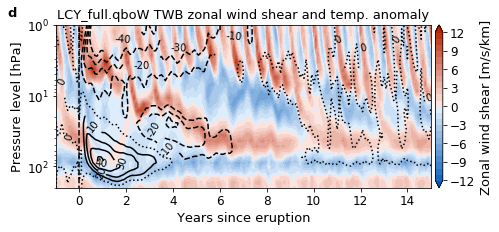

In [82]:
qbo_plot(QBOW_TWB_dUdz,QBOW_Ta_comp,cf_levels=np.linspace(-12,12,25),title='LCY_full.qboW TWB zonal wind shear and temp. anomaly',clblabel='Zonal wind shear [m/s/km]')
plt.gca().text(-0.13,1.05,'d',transform=plt.gca().transAxes,fontsize=13,weight='bold',fontname='arial')
plt.savefig('LCY_full.qboW_QBO_TWB.png',dpi=300,bbox_inches='tight')

### LCY_sulf.qboE wind and shear

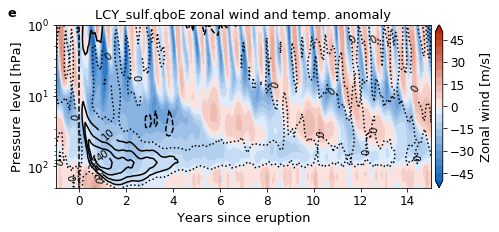

In [83]:
qbo_plot(sulf_zonmean_U,sulf_zonmean_T_anom,title='LCY_sulf.qboE zonal wind and temp. anomaly')
# plt.xlim([0,4])
plt.gca().text(-0.13,1.05,'e',transform=plt.gca().transAxes,fontsize=13,weight='bold',fontname='arial')
plt.savefig('LCY_sulf.qboE_QBO.png',dpi=300,bbox_inches='tight')

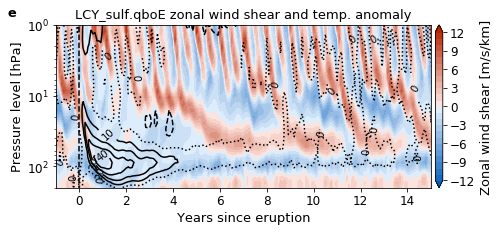

In [84]:
qbo_plot(sulf_zonmean_dUdz,sulf_zonmean_T_anom,cf_levels=np.linspace(-12,12,25),title='LCY_sulf.qboE zonal wind shear and temp. anomaly',clblabel='Zonal wind shear [m/s/km]')
plt.gca().text(-0.13,1.05,'e',transform=plt.gca().transAxes,fontsize=13,weight='bold',fontname='arial')
plt.savefig('LCY_sulf.qboE_QBO_shear.png',dpi=300,bbox_inches='tight')

In [86]:
sulf_QBOE_Tyy = differentiate_DA_lat(differentiate_DA_lat(sulf_zonmean_T))

sulf_QBOE_TWB_dUdz = (-R*sulf_QBOE_Tyy/(H*2*om/a))*1000

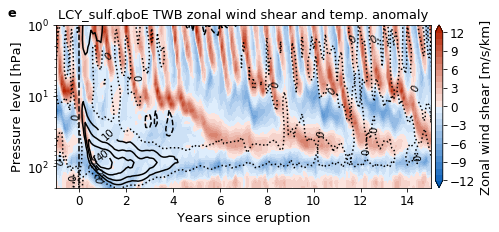

In [87]:
qbo_plot(sulf_QBOE_TWB_dUdz,sulf_zonmean_T_anom,cf_levels=np.linspace(-12,12,25),title='LCY_sulf.qboE TWB zonal wind shear and temp. anomaly',clblabel='Zonal wind shear [m/s/km]')
plt.gca().text(-0.13,1.05,'e',transform=plt.gca().transAxes,fontsize=13,weight='bold',fontname='arial')
plt.savefig('LCY_sulf.qboE_QBO_TWB.png',dpi=300,bbox_inches='tight')

### LCY_sulf.qboW wind and shear

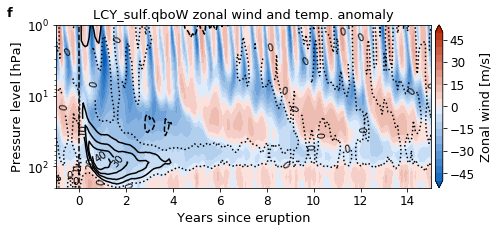

In [88]:
qbo_plot(sulf30_zonmean_U,sulf30_zonmean_T_anom,title='LCY_sulf.qboW zonal wind and temp. anomaly')
# plt.xlim([0,4])
plt.gca().text(-0.13,1.05,'f',transform=plt.gca().transAxes,fontsize=13,weight='bold',fontname='arial')
plt.savefig('LCY_sulf.qboW_QBO.png',dpi=300,bbox_inches='tight')

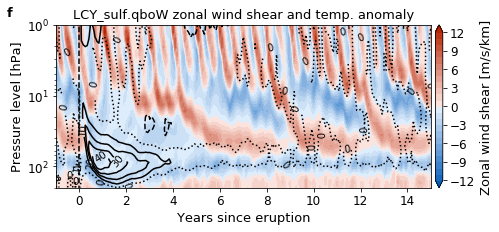

In [89]:
qbo_plot(sulf30_zonmean_dUdz,sulf30_zonmean_T_anom,cf_levels=np.linspace(-12,12,25),title='LCY_sulf.qboW zonal wind shear and temp. anomaly',clblabel='Zonal wind shear [m/s/km]')
plt.gca().text(-0.13,1.05,'f',transform=plt.gca().transAxes,fontsize=13,weight='bold',fontname='arial')
plt.savefig('LCY_sulf.qboW_QBO_shear.png',dpi=300,bbox_inches='tight')

In [90]:
sulf_QBOW_Tyy = differentiate_DA_lat(differentiate_DA_lat(sulf30_zonmean_T))

sulf_QBOW_TWB_dUdz = (-R*sulf_QBOW_Tyy/(H*2*om/a))*1000

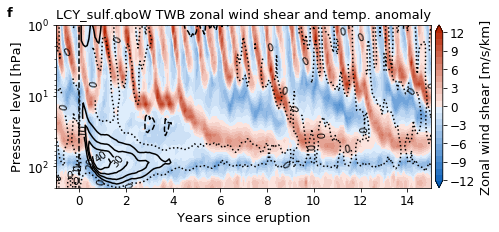

In [91]:
qbo_plot(sulf_QBOW_TWB_dUdz,sulf30_zonmean_T_anom,cf_levels=np.linspace(-12,12,25),title='LCY_sulf.qboW TWB zonal wind shear and temp. anomaly',clblabel='Zonal wind shear [m/s/km]')
plt.gca().text(-0.13,1.05,'f',transform=plt.gca().transAxes,fontsize=13,weight='bold',fontname='arial')
plt.savefig('LCY_sulf.qboW_QBO_TWB.png',dpi=300,bbox_inches='tight')

### LCY_1%halog.qboE wind and shear

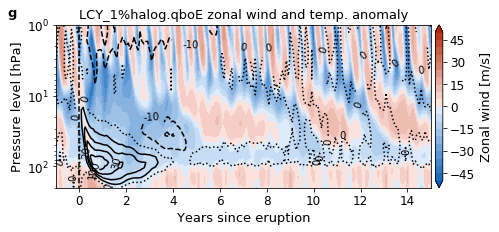

In [92]:
qbo_plot(halog_1pc_zonmean_U,halog_1pc_zonmean_T_anom,title='LCY_1%halog.qboE zonal wind and temp. anomaly')
# plt.xlim([0,4])
plt.gca().text(-0.13,1.05,'g',transform=plt.gca().transAxes,fontsize=13,weight='bold',fontname='arial')
plt.savefig('LCY_1%halog.qboE_QBO.png',dpi=300,bbox_inches='tight')

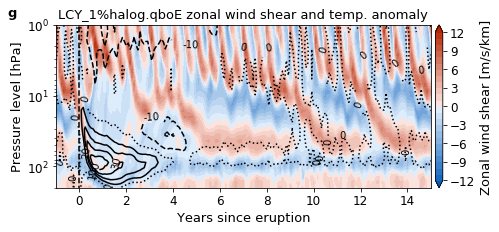

In [93]:
qbo_plot(halog1_zonmean_dUdz,halog_1pc_zonmean_T_anom,cf_levels=np.linspace(-12,12,25),title='LCY_1%halog.qboE zonal wind shear and temp. anomaly',clblabel='Zonal wind shear [m/s/km]')
plt.gca().text(-0.13,1.05,'g',transform=plt.gca().transAxes,fontsize=13,weight='bold',fontname='arial')
plt.savefig('LCY_1%halog.qboE_QBO_shear.png',dpi=300,bbox_inches='tight')

In [94]:
halog1_QBOE_Tyy = differentiate_DA_lat(differentiate_DA_lat(halog_1pc_zonmean_T))

halog1_QBOE_TWB_dUdz = (-R*halog1_QBOE_Tyy/(H*2*om/a))*1000

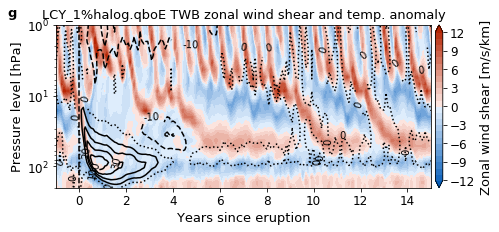

In [95]:
qbo_plot(halog1_QBOE_TWB_dUdz,halog_1pc_zonmean_T_anom,cf_levels=np.linspace(-12,12,25),title='LCY_1%halog.qboE TWB zonal wind shear and temp. anomaly',clblabel='Zonal wind shear [m/s/km]')
plt.gca().text(-0.13,1.05,'g',transform=plt.gca().transAxes,fontsize=13,weight='bold',fontname='arial')
plt.savefig('LCY_1%halog.qboE_QBO_TWB.png',dpi=300,bbox_inches='tight')

### LCY_1%sulf.qboE wind and shear

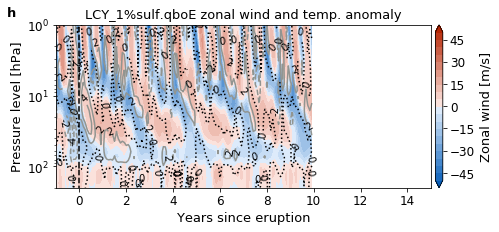

In [96]:
qbo_plot(sulf_1pc_zonmean_U,sulf_1pc_zonmean_T_anom,cs_levels=np.linspace(-4,4,5),cs_color='xkcd:grey',title='LCY_1%sulf.qboE zonal wind and temp. anomaly')
# plt.xlim([0,4])
plt.gca().text(-0.13,1.05,'h',transform=plt.gca().transAxes,fontsize=13,weight='bold',fontname='arial')
plt.savefig('LCY_1%sulf.qboE_QBO.png',dpi=300,bbox_inches='tight')

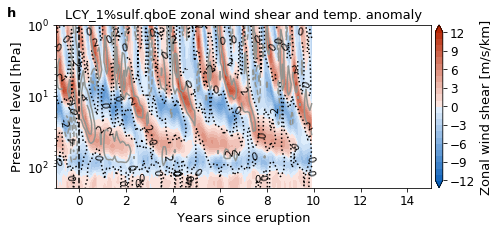

In [97]:
qbo_plot(sulf1_zonmean_dUdz,sulf_1pc_zonmean_T_anom,cs_levels=np.linspace(-4,4,5),cs_color='xkcd:grey',cf_levels=np.linspace(-12,12,25),title='LCY_1%sulf.qboE zonal wind shear and temp. anomaly',clblabel='Zonal wind shear [m/s/km]')
plt.gca().text(-0.13,1.05,'h',transform=plt.gca().transAxes,fontsize=13,weight='bold',fontname='arial')
plt.savefig('LCY_1%sulf.qboE_QBO_shear.png',dpi=300,bbox_inches='tight')

In [98]:
sulf1_QBOE_Tyy = differentiate_DA_lat(differentiate_DA_lat(sulf_1pc_zonmean_T))

sulf1_QBOE_TWB_dUdz = (-R*sulf1_QBOE_Tyy/(H*2*om/a))*1000

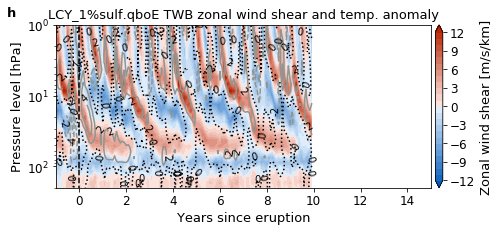

In [99]:
qbo_plot(sulf1_QBOE_TWB_dUdz,sulf_1pc_zonmean_T_anom,cs_levels=np.linspace(-4,4,5),cs_color='xkcd:grey',cf_levels=np.linspace(-12,12,25),title='LCY_1%sulf.qboE TWB zonal wind shear and temp. anomaly',clblabel='Zonal wind shear [m/s/km]')
plt.gca().text(-0.13,1.05,'h',transform=plt.gca().transAxes,fontsize=13,weight='bold',fontname='arial')
plt.savefig('LCY_1%sulf.qboE_QBO_TWB.png',dpi=300,bbox_inches='tight')

## Make control run T anomaly

In [100]:
climTconcatCTR = get_clim_with_same_dims_v2(ctrzon['T'],climzon['T'])
climTconcatCTR['time'].values=ctrzon['time'].values
#print(climTconcat.shape)
#print(ens_zonmean['T'].shape)
climTconcatCTRQBO = climTconcatCTR
# climTconcatCTRQBO

In [101]:
ctrQBOT = ctrzon['T']
ctrQBOTanom = ctrQBOT-climTconcatCTRQBO.values

In [104]:
ctrU = ctrzon['U']
ctrPS = ctrzon['PS']

## Interpolate control run fields

In [105]:
ctrU[:] = interpolator(ctrU,hyam,hybm,ctrPS,P0).values
ctrQBOT[:] = interpolator(ctrQBOT,hyam,hybm,ctrPS,P0).values
ctrQBOTanom[:] = interpolator(ctrQBOTanom,hyam,hybm,ctrPS,P0).values

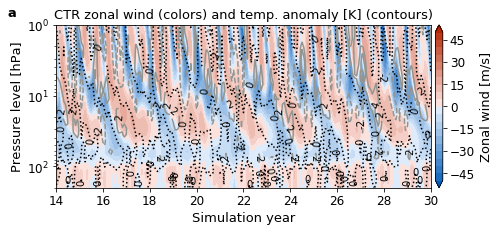

In [107]:
qbo_plot(ctrU,ctrQBOTanom,tmin=14,tmax=30,cs_levels=np.linspace(-4,4,5),cs_color='xkcd:grey',title='CTR zonal wind (colors) and temp. anomaly [K] (contours)',xlabel='Simulation year')
# plt.xlim([0,4])
plt.gca().text(-0.13,1.05,'a',transform=plt.gca().transAxes,fontsize=13,weight='bold',fontname='arial')
plt.savefig('CTR_y14-30_QBO.png',dpi=300,bbox_inches='tight')

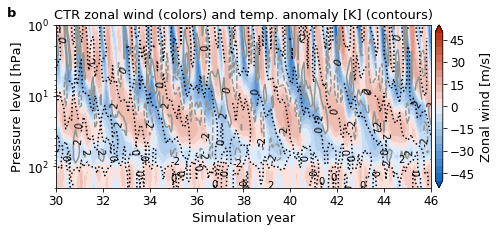

In [111]:
qbo_plot(ctrU,ctrQBOTanom,tmin=30,tmax=46,cs_levels=np.linspace(-4,4,5),cs_color='xkcd:grey',title='CTR zonal wind (colors) and temp. anomaly [K] (contours)',xlabel='Simulation year')
# plt.xlim([0,4])
plt.gca().text(-0.13,1.05,'b',transform=plt.gca().transAxes,fontsize=13,weight='bold',fontname='arial')
plt.savefig('CTR_y30-46_QBO.png',dpi=300,bbox_inches='tight')

In [112]:
ctr_dUdz = differentiate_DA_z(ctrU)*1000

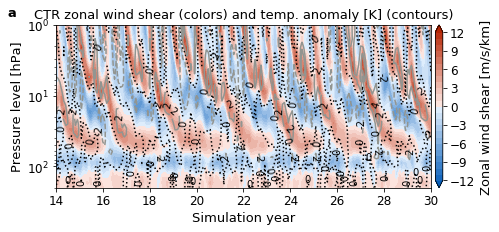

In [113]:
qbo_plot(ctr_dUdz,ctrQBOTanom,tmin=14,tmax=30,cs_levels=np.linspace(-4,4,5),cs_color='xkcd:grey',cf_levels=np.linspace(-12,12,25),title='CTR zonal wind shear (colors) and temp. anomaly [K] (contours)',clblabel='Zonal wind shear [m/s/km]',xlabel='Simulation year')
plt.gca().text(-0.13,1.05,'a',transform=plt.gca().transAxes,fontsize=13,weight='bold',fontname='arial')
plt.savefig('CTR_y14-30_QBO_shear.png',dpi=300,bbox_inches='tight')

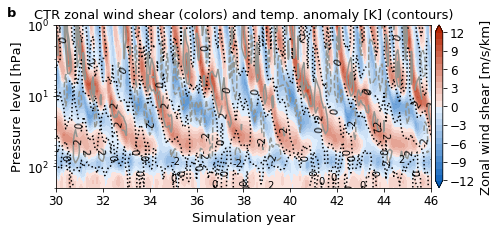

In [114]:
qbo_plot(ctr_dUdz,ctrQBOTanom,tmin=30,tmax=46,cs_levels=np.linspace(-4,4,5),cs_color='xkcd:grey',cf_levels=np.linspace(-12,12,25),title='CTR zonal wind shear (colors) and temp. anomaly [K] (contours)',clblabel='Zonal wind shear [m/s/km]',xlabel='Simulation year')
plt.gca().text(-0.13,1.05,'b',transform=plt.gca().transAxes,fontsize=13,weight='bold',fontname='arial')
plt.savefig('CTR_y30-46_QBO_shear.png',dpi=300,bbox_inches='tight')

In [115]:
ctr_Tyy = differentiate_DA_lat(differentiate_DA_lat(ctrQBOT))

ctr_TWB_dUdz = (-R*ctr_Tyy/(H*2*om/a))*1000

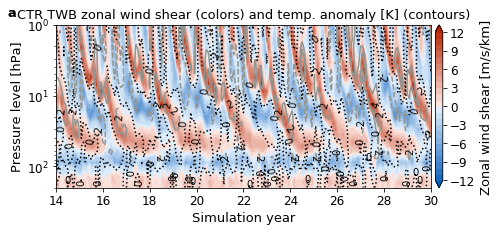

In [116]:
qbo_plot(ctr_TWB_dUdz,ctrQBOTanom,tmin=14,tmax=30,cs_levels=np.linspace(-4,4,5),cs_color='xkcd:grey',cf_levels=np.linspace(-12,12,25),title='CTR TWB zonal wind shear (colors) and temp. anomaly [K] (contours)',clblabel='Zonal wind shear [m/s/km]',xlabel='Simulation year')
plt.gca().text(-0.13,1.05,'a',transform=plt.gca().transAxes,fontsize=13,weight='bold',fontname='arial')
plt.savefig('CTR_y14-30_QBO_TWB.png',dpi=300,bbox_inches='tight')

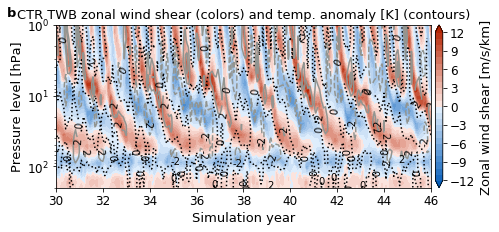

In [117]:
qbo_plot(ctr_TWB_dUdz,ctrQBOTanom,tmin=30,tmax=46,cs_levels=np.linspace(-4,4,5),cs_color='xkcd:grey',cf_levels=np.linspace(-12,12,25),title='CTR TWB zonal wind shear (colors) and temp. anomaly [K] (contours)',clblabel='Zonal wind shear [m/s/km]',xlabel='Simulation year')
plt.gca().text(-0.13,1.05,'b',transform=plt.gca().transAxes,fontsize=13,weight='bold',fontname='arial')
plt.savefig('CTR_y30-46_QBO_TWB.png',dpi=300,bbox_inches='tight')

In [118]:
! gm montage -geometry +2+2 -tile 2x4 CTR_y14-30_QBO.png CTR_y30-46_QBO.png LCY_full.qboE_QBO.png LCY_full.qboW_QBO.png LCY_sulf.qboE_QBO.png LCY_sulf.qboW_QBO.png LCY_1%halog.qboE_QBO.png LCY_1%sulf.qboE_QBO.png ens_QBO.png

In [119]:
! gm montage -geometry +2+2 -tile 2x4 CTR_y14-30_QBO_shear.png CTR_y30-46_QBO_shear.png LCY_full.qboE_QBO_shear.png LCY_full.qboW_QBO_shear.png LCY_sulf.qboE_QBO_shear.png LCY_sulf.qboW_QBO_shear.png LCY_1%halog.qboE_QBO_shear.png LCY_1%sulf.qboE_QBO_shear.png ens_QBO_shear.png

In [120]:
! gm montage -geometry +2+2 -tile 2x4 CTR_y14-30_QBO_TWB.png CTR_y30-46_QBO_TWB.png LCY_full.qboE_QBO_TWB.png LCY_full.qboW_QBO_TWB.png LCY_sulf.qboE_QBO_TWB.png LCY_sulf.qboW_QBO_TWB.png LCY_1%halog.qboE_QBO_TWB.png LCY_1%sulf.qboE_QBO_TWB.png ens_QBO_TWB.png